What this is about
================

Background
---------------

In an earlier notebook ( https://github.com/mds2/simple-polynomial-function-approximation/blob/main/poly%20approx.ipynb ) we discussed how to solve the following problem:

Given function $f(x)$ and find a $g(x) = \sum_{i=0}^n \alpha_i x^i$ that minimizes
$ \int_a^b (f(x) - g(x))^2 dx$ over some interval $(a,b)$.

We also dug up tricks to do things like
1. Constrain $g(x)$ to match $f(x)$ at the endpoints of an interval
2. Find $g(x)$ given only the inverse function to $f(x)$

In this notebook we seek to extend these tricks to higher dimensional functions.

Much of this will overlap with https://arxiv.org/abs/1208.6398 but I think the inverse tricks may be new.

For the time being, we restrict ourselves to functions from $\mathbb{R}^2 \rightarrow \mathbb{R}$ and
functions from $\mathbb{R}^2 \rightarrow \mathbb{R}^2$

Basics
--------

The same basic technique that was used in the earlier notebook will be used here : 

Recall that in 1 dimension we minimize

$ \int_a^b (f(x) - g(x))^2 dx$ over some interval $(a,b)$.

do some re-arrangements to get

$$\sum_{i=0}^n \sum_{j=0}^n \int_a^b \alpha_i \alpha_j x^{j+i}dx -
\sum_{i=0}^n 2 \int_a^b \alpha_i x^i f(x) dx +
\int_a^b f(x)^2 dx
$$

and find that what we're minimizing can be  expressed as

$ \alpha^T A \alpha - 2 B^T \alpha + C$$

where $\alpha$ is the vector of $\alpha_i$, 
$A_{i,j} = \int_a^b x^{j+i}dx = {{(b^{j+i+1} - a^{j+1+1})}\over{j+i+1}}$,
$B_i = \int_a^b f(x) x^i dx$ (often has to be computed numerically)
and $C = \int_a^b f(x)^2 dx$

For functions $\mathbb{R}^2 \rightarrow \mathbb{R}$ we now have two intervals, and powers of both $x$ and $y$,
indexed by $i$, $j$ (for $x$) and $u$, $v$ (for $y$)

We now want to minimize

$ \int_a^b {\int_c^d (f(x,y) - g(x,y))^2 dy} dx$ over $x \in (a,b)$, $y \in (c,d)$.

do some re-arrangements to get

$$\sum_{i,u=0,0}^{n,m} \sum_{j,v=0,0}^{n,m} \int_a^b \int_c^d \alpha_{i,u} \alpha_{j,v} x^{j+i} y^{u+v} dy dx -
\sum_{i,u=0,0}^{n,m} \int_a^b \int_c^d \alpha_{i,u} x^i y^u f(x,y) dy dx +
\int_a^b \int_c^d f(x,y)^2 dy dx
$$

and get an equivalent matrix expression for $\alpha_{i,u}$ as an unrolled column vector of coefficients

In [21]:
import numpy as np
from matplotlib import pyplot as plt

In [22]:
def integrate(f, bounds=[[0.0, 1.0], [0.0, 1.0]]):
    """Rather than relying on a hand-rolled numerical integration routine, as in the
    notebook for the 1-dimensional case, we will attempt to use scipy's numerical double-integration
    routine.  It is faster, easier to use, and requires fewer fiddly parameters"""
    try:
        from scipy.integrate import dblquad
        area, err = dblquad(f, bounds[0][0], bounds[0][1], lambda t: bounds[1][0], lambda t: bounds[1][1])
        return area
    except:
        print("Could not import from scipy.integrate, integration will be slow and inaccurate")
    nsteps = [1000, 1000]
    b = np.array(bounds)
    w = b[:,1] - b[:,0]
    h = w / np.array(nsteps)
    start = b[0,0] + 0.5 * h
    xs = [h[0]*i + start[0] for i in range(nsteps[0])]
    ys = [h[1]*j + start[1] for j in range(nsteps[1])]
    slices = [sum([f(x,y) * h[0] for x in xs]) for y in ys]
    areas = [s*h[1] for s in slices]
    return sum(areas)

In [3]:
integrate(lambda x,y: x*y) # should be 1/4

0.24999999999999997

Coefficient matrices
===================

Now we write the routines to calculate the coefficients of the matrix needed to minimize
the matrix quadratic equation outlined above

An important implementation detail is that the $\alpha_{i,u}$ in the solution are ordered by $u$ first and then
by $i$.

This will become relevant when we try to evaluate the resulting polynomials.

The exact ordering is unimportant, except that we need to be consistent with it for properly
unrolling the vector of coefficients into an $n \times m$ matrix in order to help with evaluation.

In particular, if we re-order the $\alpha_{i,u}$ into an $n \times m$ matrix $M$ then we can express our polynomial as

$$ g(x,y) = [x^0, x^1, ..., x^{n-1}] M [y^0, y^1, ..., y^{m-1}]^T $$

In [68]:
def get_a(n, m, bounds=[[0.0, 1.0], [0.0, 1.0]]):
    x0 = bounds[0][0]
    x1 = bounds[0][1]
    y0 = bounds[1][0]
    y1 = bounds[1][1]
    els = [[(x1 **  (i + j + 1) - x0 ** (i + j + 1)) *
            (y1 ** ( u + v + 1) - y0 ** (u + v + 1))/((i+j+1) * (u + v + 1))
            for j in range(n) for v in range(m)]
           for i in range(n) for u in range(m)]
    return np.array(els)

def get_b(n, m, f, bounds=[[0.0, 1.0], [0.0, 1.0]]):
    els = [integrate(lambda x, y: x**i * y ** u * f(x, y),
                            bounds=bounds)
           for i in range(n) for u in range(m)]
    return np.array(els)

def get_c(f, bounds=[[0.0, 1.0], [0.0, 1.0]]):
    return integrate(lambda x,y: f(x,y) * f(x,y), bounds=bounds)

In [69]:
def solve_coeffs(a,b,_c):
    """This solves for our coefficients given the elements of the matrix expression
    for approximation error"""
    return np.linalg.solve(a, b)

Tying it together
-------------

Here we combine the coefficient solve, the re-formatting of the coefficient vector into an $n \times m$ matrix,
and the construction of the resulting function.

We also take the quadratic matrix equation we minimized to find our coefficients and
evaluate it at our coefficient solution, to find our error.

In [70]:
def solve(f, n, m, bounds=[[0.0, 1.0], [0.0, 1.0]]):
    a = get_a(n,m, bounds=bounds)
    b = get_b(n,m, f, bounds=bounds)
    c = get_c(f, bounds=bounds)
    unrolled = solve_coeffs(a, b, c)
    err = np.dot(np.dot(unrolled.T, a) - 2.0 * b, unrolled) + c
    print("err estimate is " + str(err))
    poly_mat = unrolled.reshape((n, m))
    return poly_mat, err

Let's try this on some simple things with exact polynomial fits

This is mostly just sanity checking, the "error" should be near zero, the appropriate row/column
of the polynomial matrix should be near 1, and all other entries should be near zero

In [71]:
solve(lambda x,y: x * y, 2, 2)

err estimate is -2.7755575615628914e-17


(array([[-7.77156117e-16,  9.99200722e-16],
        [ 9.99200722e-16,  1.00000000e+00]]),
 -2.7755575615628914e-17)

In [72]:
solve(lambda x,y: x * y, 3, 2)

err estimate is -4.163336342344337e-17


(array([[-4.13558077e-15,  5.99520433e-15],
        [ 2.09832152e-14,  1.00000000e+00],
        [-1.99840144e-14,  2.99760217e-14]]),
 -4.163336342344337e-17)

In [73]:
solve(lambda x,y: x + x*y, 2, 3)

err estimate is -1.1102230246251565e-16


(array([[-1.24344979e-14,  6.79456491e-14, -6.49480469e-14],
        [ 1.00000000e+00,  1.00000000e+00,  1.04916076e-13]]),
 -1.1102230246251565e-16)

Using the results
---------

Here we introduce helper functions that make it easier to convert the sort of polynomial coefficient
matrix we solved for above into a function that can be evaluated

In [74]:

def poly_vec(x, degree):
    """Takes input x and converts it to [x^0, x^1, ..., x^{degree-1}]"""
    result = np.zeros((degree,) + np.array(x).shape)
    result[0] = 1.0
    for i in range(1, degree):
        result[i] = x * result[i-1]
    return result

def poly_mat_to_func(m):
    """Takes as input a matrix of polynomial coefficients and returns a lambda
    that evaluates the represented polynomial on a given x and y"""
    return lambda x,y: np.dot(poly_vec(x, m.shape[0]).T, np.dot(m, poly_vec(y, m.shape[1])))



Plotting
---------------------

Here we wrap our `solve` into a function that plots the surface of the target function, the approximating function,
and the two of them overlaid.

We use the `mpl_toolkits` library for python, and introduce a new helper function (`apply_poly_mat_to_meshgrid`) to
apply our computed polynomial, in parallel, to every item of the sort of `meshgrid` matrix data structure
that `mplot3d` expects

In [75]:
from mpl_toolkits import mplot3d

In [76]:
def apply_poly_mat_to_meshgrid(m, x, y):
    """Helper function to apply a polynomial with coefficients given by m
    in parallel to every x and y in a meshgrid"""
    x_stripe = x[0,:]
    y_stripe = y[:,0]
    return poly_mat_to_func(m)(x_stripe, y_stripe).T

def solve_and_show(f, n, m, bounds=[[0.0, 1.0], [0.0, 1.0]]):
    """Solve for a multinomial approximation to a given function from R^2 to R
    plot the approximation, the original function, and the two together.
    
    Return the coefficient matrix and the error of approximation"""
    mat, err = solve(f, n, m, bounds)
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    x = np.linspace(bounds[0][0], bounds[0][1], 30)
    y = np.linspace(bounds[1][0], bounds[1][1], 30)

    deltas = x[1] - x[0], y[1] - y[0]

    X, Y = np.meshgrid(x, y)
    print(X.shape)
    Z = apply_poly_mat_to_meshgrid(mat, X, Y)
    Z_ref = f(X + deltas[0], Y + deltas[1])
    ax.plot_wireframe(X + deltas[0], Y + deltas[1], Z_ref, color='red')
    ax.plot_wireframe(X, Y, Z, color='blue')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot_wireframe(X + deltas[0], Y + deltas[1], Z_ref, color='red')
    
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot_wireframe(X, Y, Z, color='blue')

    plt.show()
    return mat, err

Now let's test it!
----------------------

First we'll try it on some functions that are literal multinomial expressions.

It should return a closely matching function with almost zero error

err estimate is -2.7755575615628914e-17
(30, 30)


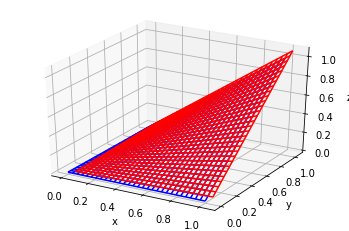

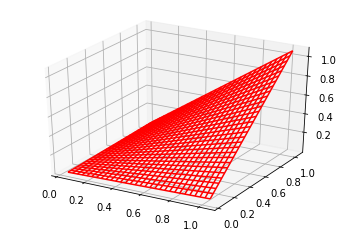

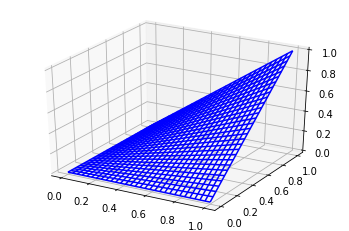

(array([[-1.54751212e-13,  7.68912711e-13, -7.02354841e-13],
        [ 1.73577819e-12,  1.00000000e+00,  7.86870569e-12],
        [-4.18415302e-12,  2.07833750e-11, -1.89348537e-11],
        [ 2.72198930e-12, -1.35108591e-11,  1.22984956e-11]]),
 -2.7755575615628914e-17)

In [77]:
solve_and_show(lambda x, y: x * y, 4, 3)

err estimate is -1.1102230246251565e-16
(30, 30)


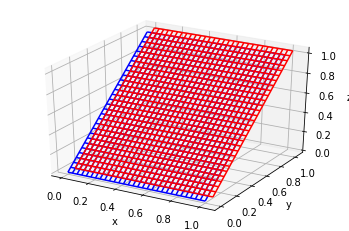

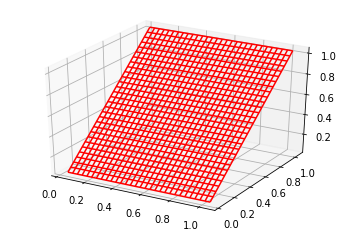

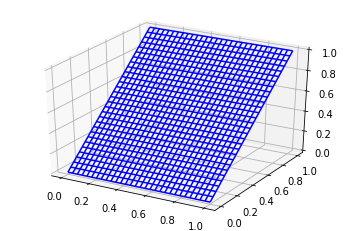

(array([[-2.78325141e-11,  1.00000000e+00, -2.32941618e-09,
          3.54707816e-09, -1.74564468e-09],
        [ 5.09969833e-10, -9.78120903e-09,  4.27322007e-08,
         -6.50879901e-08,  3.20387465e-08],
        [-2.16945795e-09,  4.16290077e-08, -1.81913471e-07,
          2.77128185e-07, -1.36429060e-07],
        [ 3.24497801e-09, -6.22884782e-08,  2.72242979e-07,
         -4.14786896e-07,  2.04215845e-07],
        [-1.57624012e-09,  3.02647897e-08, -1.32296764e-07,
          2.01585015e-07, -9.92549335e-08]]),
 -1.1102230246251565e-16)

In [78]:
solve_and_show(lambda x, y: y, 5, 5)

Testing on non-trivial cases
-----------------------

Now let's try it on functions that aren't simple multinomial expressions

err estimate is 0.001254737473411982
(30, 30)


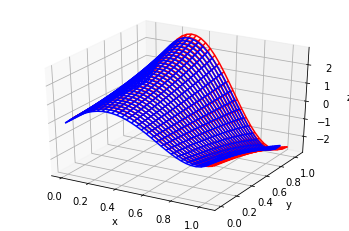

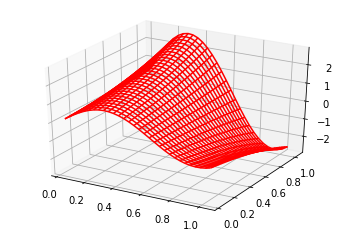

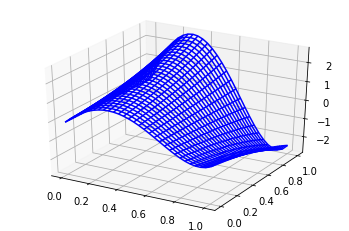

(array([[-5.09038709e-02, -5.08222109e-02, -2.59890915e-02,
         -7.10900183e-03, -3.53667416e-03],
        [ 6.33253200e+00,  6.32237343e+00,  3.23308887e+00,
          8.84372876e-01,  4.39968356e-01],
        [-7.16896371e+00, -7.15746326e+00, -3.66013131e+00,
         -1.00118473e+00, -4.98081727e-01],
        [-1.16537794e+01, -1.16350847e+01, -5.94986327e+00,
         -1.62751542e+00, -8.09674672e-01],
        [ 1.16550619e+01,  1.16363651e+01,  5.95051839e+00,
          1.62769409e+00,  8.09763991e-01]]),
 0.001254737473411982)

In [79]:
solve_and_show(lambda x, y: np.sin(5.0 * x) * np.exp(y), 5, 5)

err estimate is 0.16610555169884922
(30, 30)


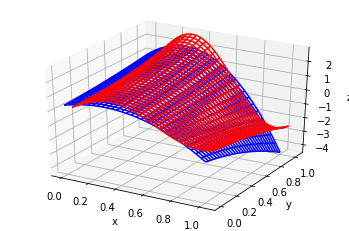

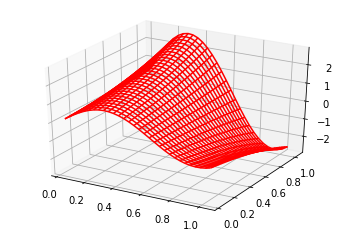

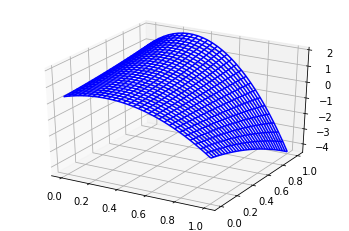

In [80]:
m_nonpoly, err_nonpoly = solve_and_show(lambda x, y: np.sin(5.0 * x) * np.exp(y), 3, 3)

Now to test to make sure our error estimates are accurate

In [81]:
errfunc_nonpoly = lambda x,y: poly_mat_to_func(m_nonpoly)(x,y) - np.sin(5.0 * x) * np.exp(y)

In [82]:
integrate(lambda x,y: (errfunc_nonpoly(x,y))**2, [[0,1],[0,1]])

0.1661055516988495

err estimate is 0.0859537794714107
(30, 30)


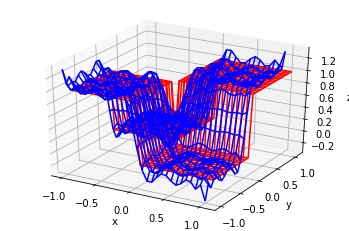

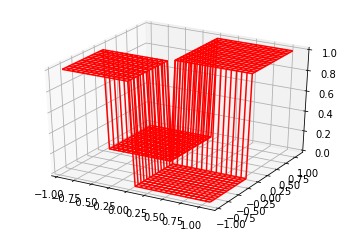

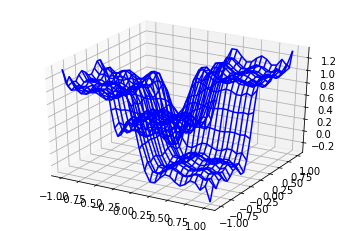

In [83]:
mstep, errstep = solve_and_show(lambda x, y: np.heaviside(x, 0) * np.heaviside(y, 0) + np.heaviside(-x, 0) * np.heaviside(-y, 0), 15, 15, [[-1,1],[-1,1]])

In [84]:
errfunc_step = lambda x,y: poly_mat_to_func(mstep)(x,y) - (np.heaviside(x, 0) * np.heaviside(y, 0) + np.heaviside(-x, 0) * np.heaviside(-y, 0))

In [85]:
integrate(lambda x,y: (errfunc_step(x,y))**2, [[-1,1],[-1,1]])

0.08588525187235259